In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Simple GPT example

In [2]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')

from gpt import GPT

In [3]:
G = GPT(input_file=INPUT_FILE, verbose=True)

Configured to run in /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpefv69vm8


In [4]:
# Available variables
G.input['variables']

{'data_dump': 0.0,
 'Master_RF': 1300000000.0,
 'MTE': 120.0,
 'gun_voltage': 300.0,
 'sol_1_current': 3.32107,
 'auto_phase': 0.0,
 'single_particle': 0.0,
 'space_charge': 1.0,
 'space_charge_type': 1.0,
 'viewscreens_on': 1.0,
 'kill_backwards_particles': 1.0,
 'optimize_on': 0.0,
 'xoffset': 0.0,
 'yoffset': 0.0,
 'RadiusMax': 0.04,
 'GBacc': 5.5,
 'xacc': 6.5,
 'dtmin': 1e-16,
 'dtmax': 1e-10,
 'ZSLA01': 0.344,
 'ZCTB01': 0.746,
 'ZSLA02': 1.16,
 'Zdcgun': 0.15,
 'Maxdcgun': 500.0,
 'SLAPolarity': -1.0,
 'LSLA01': 0.6,
 'XSLA01': 0.0,
 'YSLA01': 0.0,
 'THXSLA01': 0.0,
 'IA1SDR01_z': 0.922,
 'ZSTOP': 1.5,
 'Alpha': 1.0,
 'Fn': 0.5,
 'verror': 0.005,
 'Nstd': 5.0,
 'tree_code_theta': 1.0,
 'tree_code_R': 1e-06,
 'Ntout': 50.0,
 'tmax': 1e-08,
 'ZSTART': -0.005}

In [5]:
import sys, os
root = os.path.join(os.getcwd(), '../')
INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')
sys.path.append(root)

In [6]:
# Set some of these
variables_were_set = G.set_variables({'gun_voltage':375,'sol_1_current':-3})
print(variables_were_set)

[True, True]


In [7]:
# Run
G.run()

init dir:  /Users/colwyngulliford/Documents/GitHub/lume-gpt/examples
running GPT in /private/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpefv69vm8

General Particle Tracer - Oct 28 2014


In [8]:
# Ouput
G.output.keys()

dict_keys(['particles', 'start_time', 'run_time', 'run_error'])

In [9]:
# Raw screens
len(G.screen)

1

In [10]:
# Raw touts 
len(G.tout)

32

In [11]:
# Info
print(G)

GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.4651069641113281 (sec)


In [12]:
# Unique fingerprint based on input
G.fingerprint()

'84ec024ccba99acebdeabc26f3983f07'

# Particle stats

In [13]:
# Some statistic that can be calculated on the particles
G.stat('norm_emit_x')

array([1.74030520e-06, 5.05909040e-06, 9.42959863e-06, 4.14775510e-06,
       4.45535914e-06, 4.78537885e-06, 6.04877282e-06, 1.37250961e-05,
       2.36687039e-05, 1.35630072e-05, 6.72500649e-06, 5.54286370e-06,
       5.33795109e-06, 5.28033365e-06, 5.26623428e-06, 5.28496931e-06,
       5.31665694e-06, 5.35511987e-06, 5.39594978e-06, 5.43613618e-06,
       5.47522119e-06, 5.51203764e-06, 5.54623121e-06, 5.57758645e-06,
       5.60675337e-06, 5.63374633e-06, 5.65841850e-06, 5.68083101e-06,
       5.70121776e-06, 5.71991618e-06, 5.73705441e-06, 5.75273071e-06])

In [14]:
# The units
G.stat_units('norm_emit_x')

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

# Plot Statistics

In [15]:
from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (12,10)

Text(0,0.5,'norm_emit_x (m)')

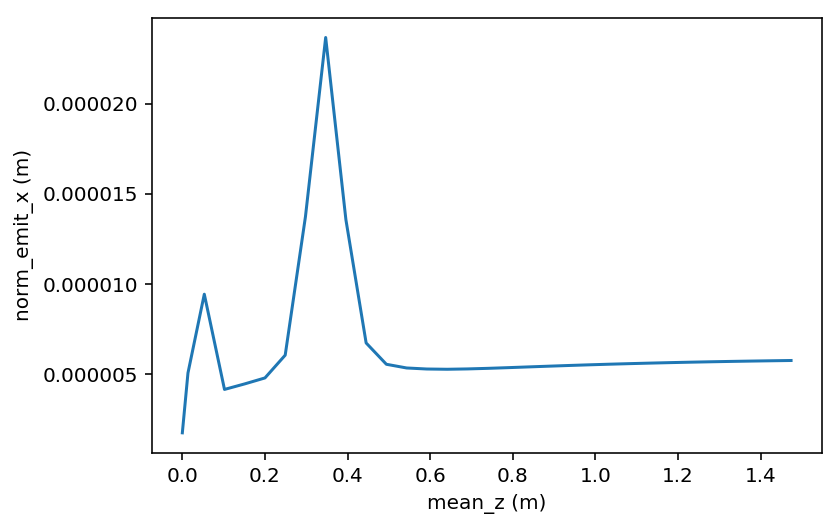

In [16]:
key1 = 'mean_z'
key2 = 'norm_emit_x'
dat1 = G.stat(key1)
dat2 = G.stat(key2)
units1 = G.stat_units(key1)
units2 = G.stat_units(key2)

fig, ax = plt.subplots()
ax.plot(dat1, dat2)
ax.set_xlabel(key1+f' ({units1})')
ax.set_ylabel(key2+f' ({units2})')

# Particle Densities


In [17]:
from pmd_beamphysics.plot import marginal_plot

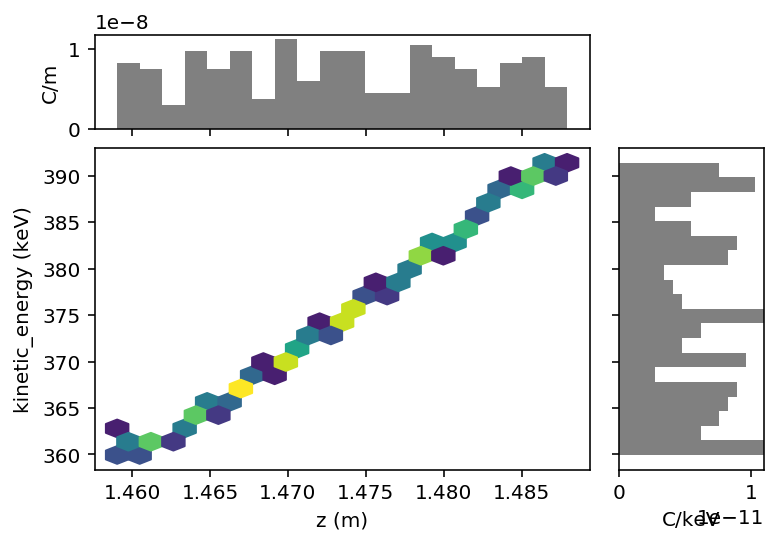

In [18]:
P = G.output['particles'][-1]

marginal_plot(P, 'z', 'kinetic_energy', bins=20)

In [19]:
# Running using the run_gpt: the actions above are combined into one user function
from gpt.gpt import run_gpt

In [20]:
G = run_gpt(settings={'gun_voltage':375,'sol_1_current':-3},
            gpt_input_file=INPUT_FILE)

In [21]:
print(G)

GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.483820915222168 (sec)


# Running with Distgen

In [47]:
from gpt.gpt_distgen import run_gpt_with_distgen
GPT_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/distgen.in.yaml')

settings = {'gun_voltage':500,
            'sol_1_current':-4.5,
            'r_dist:max_r:value':2.5,
            'total_charge:value':50,
            'n_particle':200}

G = run_gpt_with_distgen(settings=settings,
                         gpt_input_file=GPT_INPUT_FILE,
                         distgen_input_file=DISTGEN_INPUT_FILE,
                         verbose=False)

In [48]:
print(G)

GPT object:
   Original input file: gpt.in
   Use temp directory: True
   Work directory: None

Run Control
   Run configured: True
   Using temp directory: False
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.354032039642334 (sec)


In [43]:
# Plot initial particle distribution
import numpy as np
from gpt.parsers import read_particle_gdf_file
particles=read_particle_gdf_file(os.path.join(G.tempdir.name,'distgen_gpt_particles.gdf'))

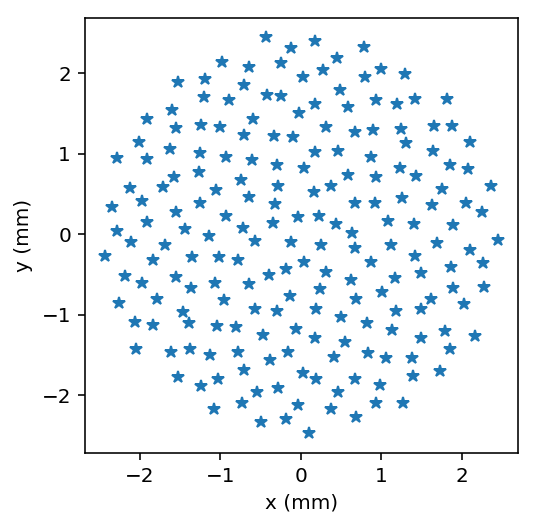

In [49]:
plt.figure()
plt.plot(1000*particles['x'],1000*particles['y'],'*')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

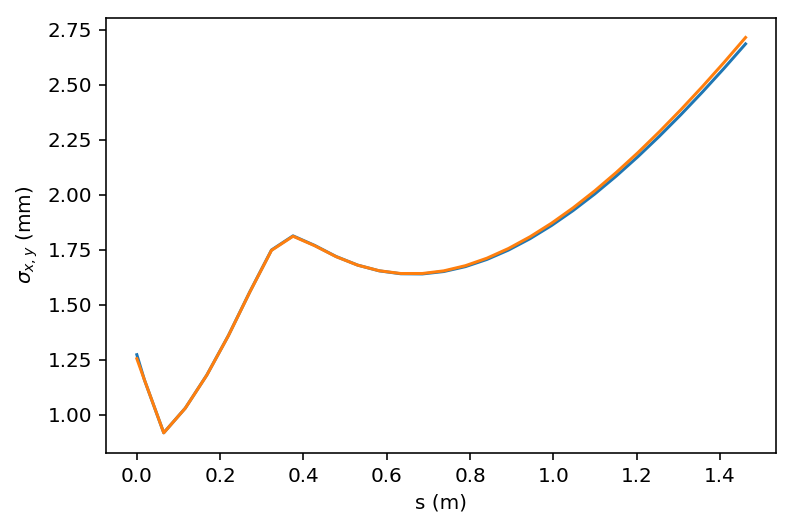

In [40]:
avgz = G.stat('mean_z')
stdx = 1000*G.stat('sigma_x')
stdy = 1000*G.stat('sigma_y')
plt.figure()
plt.plot(avgz,stdx,avgz,stdy)
plt.xlabel('s (m)')
plt.ylabel('$\sigma_{x,y}$ (mm)')
plt.show()

In [26]:
# Using the Evaluate method:

In [50]:
from gpt.evaluate import evaluate

result = evaluate(settings=settings,
                  simulation='gpt_with_distgen',
                  gpt_input_file=GPT_INPUT_FILE,
                  distgen_input_file=DISTGEN_INPUT_FILE,
                  verbose=False)

In [42]:
result

{'error': False,
 'end_std_x': 0.0017768112399142205,
 'end_std_y': 0.0017848747656373863,
 'end_qbunch': 4.9999999999999995e-11,
 'end_norm_emitt_x': 1.1799872951579944e-06,
 'end_norm_emitt_y': 1.1758424007192168e-06,
 'end_std_t': 9.971742887701527e-12,
 'fingerprint': 'b8efc909d0f54ac2896f9fa5fbeca4e4'}